# Exploratory data analysis

In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Exploratory Spatial Data Analysis
import esda  # https://pysal.org/esda/index.html
from shapely.geometry import Point
import geopandas as gpd

from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder \
    .master("local") \
    .appName("MySparkApp") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

data_path = "gs://pstat235-project-zw/"

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/02/22 03:21:20 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/02/22 03:21:20 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/02/22 03:21:20 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/02/22 03:21:20 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [3]:
nd_df = spark.read \
    .format("csv") \
    .option("header", "true") \
    .option("nullValue", "NA") \
    .option("delimiter", "\t") \
    .option("inferSchema", "true") \
    .load(os.path.join(data_path, "unzipped_data/VM2Uniform--ND--2021-03-18.tab"))

nd_df.printSchema()

root
 |-- SEQUENCE: integer (nullable = true)
 |-- LALVOTERID: string (nullable = true)
 |-- Voters_Active: string (nullable = true)
 |-- Voters_StateVoterID: integer (nullable = true)
 |-- Voters_CountyVoterID: string (nullable = true)
 |-- VoterTelephones_LandlineAreaCode: integer (nullable = true)
 |-- VoterTelephones_Landline7Digit: string (nullable = true)
 |-- VoterTelephones_LandlineFormatted: string (nullable = true)
 |-- VoterTelephones_LandlineUnformatted: long (nullable = true)
 |-- VoterTelephones_LandlineConfidenceCode: integer (nullable = true)
 |-- VoterTelephones_CellPhoneOnly: boolean (nullable = true)
 |-- VoterTelephones_CellPhoneFormatted: string (nullable = true)
 |-- VoterTelephones_CellPhoneUnformatted: long (nullable = true)
 |-- VoterTelephones_CellConfidenceCode: integer (nullable = true)
 |-- Voters_FirstName: string (nullable = true)
 |-- Voters_MiddleName: string (nullable = true)
 |-- Voters_LastName: string (nullable = true)
 |-- Voters_NameSuffix: string

In [5]:
us_counties_df = spark.read \
    .format("csv") \
    .option("header", "true") \
    .option("nullValue", "NA") \
    .option("delimiter", ",") \
    .option("inferSchema", "true") \
    .load(os.path.join(data_path, "unzipped_data/uscounties.csv"))

In [6]:
nd_df.select(
    "ElectionReturns_G08CountyTurnoutAllRegisteredVoters", 
    "EthnicGroups_EthnicGroup1Desc", "CountyEthnic_LALEthnicCode"
).show(5)

+---------------------------------------------------+-----------------------------+--------------------------+
|ElectionReturns_G08CountyTurnoutAllRegisteredVoters|EthnicGroups_EthnicGroup1Desc|CountyEthnic_LALEthnicCode|
+---------------------------------------------------+-----------------------------+--------------------------+
|                                                56%|                     European|                      null|
|                                                56%|                     European|                      null|
|                                                56%|                         null|                      null|
|                                                56%|                         null|                      null|
|                                                56%|                     European|                      null|
+---------------------------------------------------+-----------------------------+--------------------------+
o

In [7]:
print(f"Before dropna, there are {nd_df.count()} records. \n")
print(f"After dropna, there are {nd_df.dropna().count()} records.")

Before dropna, there are 422720 records. 



23/02/22 03:22:46 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


After dropna, there are 0 records.


You cannot simply apply `dropna` to the whole dataframe.

In [8]:
ethnicgp_count_nd_df = nd_df.select("EthnicGroups_EthnicGroup1Desc") \
    .dropna() \
    .groupby("EthnicGroups_EthnicGroup1Desc") \
    .count()

ethnicgp_count_nd_df.show(truncate=False)

+-----------------------------+------+
|EthnicGroups_EthnicGroup1Desc|count |
+-----------------------------+------+
|East and South Asian         |3998  |
|European                     |334609|
|Other                        |7515  |
|Likely African-American      |922   |
|Hispanic and Portuguese      |8096  |
+-----------------------------+------+



In [9]:
ethnicgp_count_nd_pddf = ethnicgp_count_nd_df.toPandas()
ethnicgp_count_nd_pddf

,EthnicGroups_EthnicGroup1Desc,count
0,East and South Asian,3998
1,European,334609
2,Other,7515
3,Likely African-American,922
4,Hispanic and Portuguese,8096


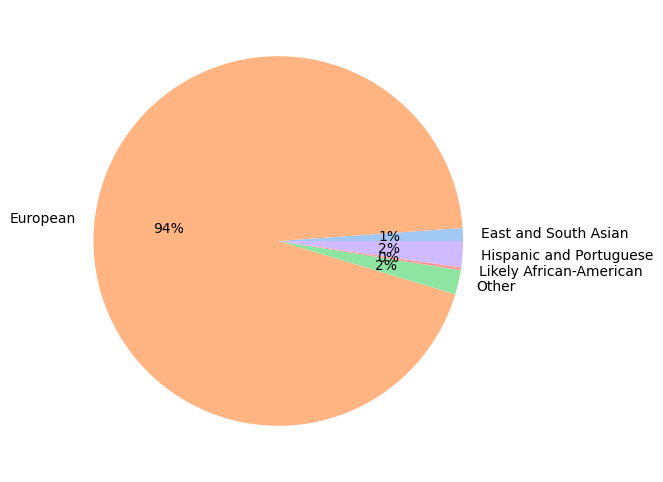

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette('pastel')[0:5]
ax.pie(
    ethnicgp_count_nd_pddf['count'], 
    labels=ethnicgp_count_nd_pddf['EthnicGroups_EthnicGroup1Desc'], 
    colors=colors, autopct='%.0f%%'
)
plt.show()

LALVOTERID: Permanent and unique ID generated by L2 for a single voter \
ElectionReturns_G08CountyTurnoutAllRegisteredVoters: County percentage of voters having voted in specified election

In [11]:
g08_turnout_count_nd_df = nd_df.select("ElectionReturns_G08CountyTurnoutAllRegisteredVoters") \
    .dropna() \
    .groupby("ElectionReturns_G08CountyTurnoutAllRegisteredVoters") \
    .count()

g08_turnout_count_nd_df.show(truncate=False)

+---------------------------------------------------+------+
|ElectionReturns_G08CountyTurnoutAllRegisteredVoters|count |
+---------------------------------------------------+------+
|54%                                                |76256 |
|36%                                                |2696  |
|56%                                                |8419  |
|51%                                                |20580 |
|67%                                                |669   |
|53%                                                |10643 |
|50%                                                |112289|
|57%                                                |7737  |
|49%                                                |4752  |
|55%                                                |4908  |
|47%                                                |49336 |
|48%                                                |30636 |
|46%                                                |6184  |
|52%                    

In [12]:
nd_df.select(
    "Residence_Addresses_Property_LandSq_Footage", "Residence_Addresses_Property_HomeSq_Footage"
).dropna().show(5, truncate=False)

+-------------------------------------------+-------------------------------------------+
|Residence_Addresses_Property_LandSq_Footage|Residence_Addresses_Property_HomeSq_Footage|
+-------------------------------------------+-------------------------------------------+
|6503000                                    |1200                                       |
|6503000                                    |1200                                       |
|391000                                     |600                                        |
|391000                                     |600                                        |
|391000                                     |600                                        |
+-------------------------------------------+-------------------------------------------+
only showing top 5 rows



In [16]:
voters_df = nd_df.select(
    "LALVOTERID", "Voters_FirstName", "Voters_LastName", 
    "Residence_Addresses_Longitude", "Residence_Addresses_Latitude", 
    "Residence_Addresses_Property_HomeSq_Footage"
) \
    .dropna()

print(f"voter_nd_df has {voters_df.count()} records.")
voters_nd_df.show(5, truncate=False)

voter_nd_df has 165732 records.
+--------------+----------------+---------------+-----------------------------+----------------------------+-------------------------------------------+
|LALVOTERID    |Voters_FirstName|Voters_LastName|Residence_Addresses_Longitude|Residence_Addresses_Latitude|Residence_Addresses_Property_HomeSq_Footage|
+--------------+----------------+---------------+-----------------------------+----------------------------+-------------------------------------------+
|LALND462587305|Gena            |Ertelt         |-97.828399                   |46.918498                   |1200                                       |
|LALND15911    |Jeffrey         |Ertelt         |-97.828399                   |46.918498                   |1200                                       |
|LALND21339    |Karen           |Anderson       |-97.788869                   |47.081127                   |600                                        |
|LALND504885535|William         |Anderson       |-

In [18]:
voters_pddf = voters_df.toPandas()
voters_pddf.head()

,LALVOTERID,Voters_FirstName,Voters_LastName,Residence_Addresses_Longitude,Residence_Addresses_Latitude,Residence_Addresses_Property_HomeSq_Footage
0,LALND462587305,Gena,Ertelt,-97.828399,46.918498,1200
1,LALND15911,Jeffrey,Ertelt,-97.828399,46.918498,1200
2,LALND21339,Karen,Anderson,-97.788869,47.081127,600
3,LALND504885535,William,Anderson,-97.788869,47.081127,600
4,LALND504885655,Kayla,Anderson,-97.788869,47.081127,600


In [19]:
# geodataframe of voters
geometry = [
    Point(xy) for xy in zip(
        voters_pddf["Residence_Addresses_Longitude"], 
        voters_pddf["Residence_Addresses_Latitude"]
    )
]
voters_gdf = gpd.GeoDataFrame(
    voters_pddf, crs="EPSG:4326", geometry=geometry
)

In [20]:
# read shapefiles
counties_gpd = gpd.read_file(
    os.path.join(
        data_path, "shp/Counties.shp"
    )
)

print(f"Number of records in counties_gpd: {len(counties_gpd)}")
counties_gpd.head()

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/miniconda3/share/proj failed


Number of records in counties_gpd: 3141


,ObjectID,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,POP2000,POP2004,POP00_SQMI,POP04_SQMI,...,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,NO_FARMS97,AVG_SIZE97,CROP_ACR97,AVG_SALE97,SQMI,geometry
0,0,Gallatin,Montana,30,031,30031,67831,74167,25.8,28.2,...,29489,3166,16434,9889,835,910,252837,70.55,2632.2,"POLYGON ((-111.37231 44.74509, -111.36918 45.3..."
1,1,Monroe,Florida,12,087,12087,79589,80976,79.8,81.2,...,51617,16531,21893,13193,13,95,0,0.00,997.2,"MULTIPOLYGON (((-81.25621 25.80310, -80.87454 ..."
2,2,Kalawao,Hawaii,15,005,15005,147,143,11.2,10.8,...,172,57,0,115,-99,-99,-99,-99.00,13.2,"POLYGON ((-156.91021 21.15805, -156.89743 21.1..."
3,3,Kauai,Hawaii,15,007,15007,58463,60165,93.2,95.9,...,25331,5148,12384,7799,468,421,0,122.81,627.3,"MULTIPOLYGON (((-159.33518 21.94834, -159.4395..."
4,4,Honolulu,Hawaii,15,003,15003,876156,894358,1461.9,1492.3,...,315988,29538,156290,130160,880,91,29237,162.46,599.3,"POLYGON ((-157.67333 21.29803, -157.68137 21.2..."


In [21]:
nd_counties_gpd = counties_gpd.loc[counties_gpd["STATE_NAME"] == "North Dakota"]

print(f"Number of records in nd_counties_gpd: {len(nd_counties_gpd)}")
nd_counties_gpd.head()

Number of records in nd_counties_gpd: 53


,ObjectID,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,POP2000,POP2004,POP00_SQMI,POP04_SQMI,...,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,NO_FARMS97,AVG_SIZE97,CROP_ACR97,AVG_SALE97,SQMI,geometry
149,149,Ward,North Dakota,38,101,38101,58795,57939,28.6,28.2,...,25097,2056,14434,8607,1172,1030,949278,70.74,2056.5,"POLYGON ((-100.96471 47.85409, -101.87778 47.8..."
150,150,McLean,North Dakota,38,055,38055,9311,8994,4.0,3.9,...,5264,1449,3135,680,969,1179,866193,76.65,2327.8,"POLYGON ((-101.26044 47.26665, -101.28171 47.2..."
151,151,Williams,North Dakota,38,105,38105,19761,19276,9.2,9.0,...,9680,1585,5778,2317,850,1418,829313,62.38,2148.0,"POLYGON ((-102.82546 48.12738, -102.85777 48.1..."
153,153,Mercer,North Dakota,38,057,38057,8644,8520,7.8,7.7,...,4402,1056,2828,518,473,1165,283584,48.71,1112.4,"POLYGON ((-101.76554 46.98543, -102.10465 46.9..."
155,155,Golden Valley,North Dakota,38,033,38033,1924,1847,1.9,1.8,...,973,212,594,167,244,2372,221203,74.86,1002.4,"POLYGON ((-104.04671 46.54254, -104.04744 46.6..."


<AxesSubplot:>

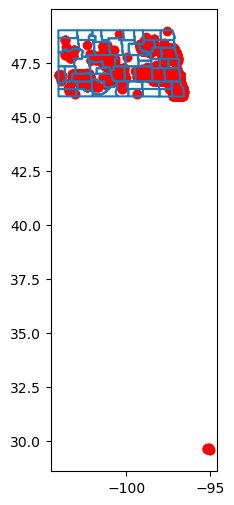

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
nd_counties_gpd.boundary.plot(ax=ax)
voters_gdf.plot(ax=ax, color='red')

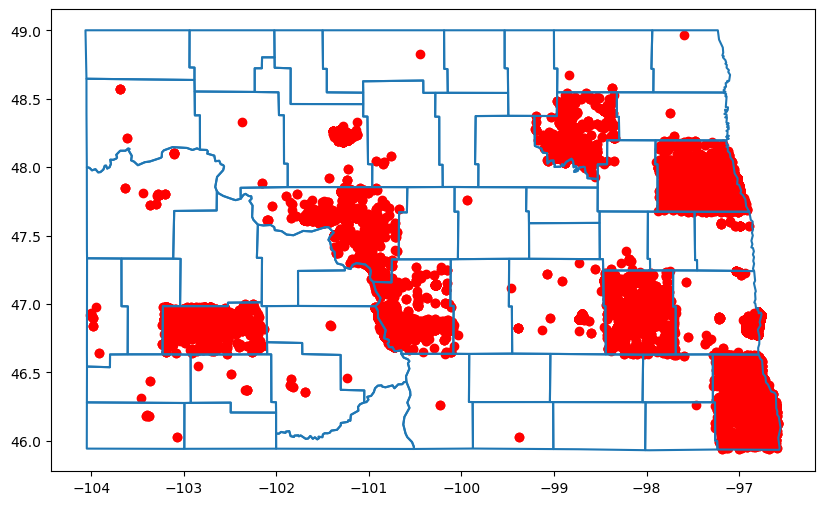

In [23]:
# remove outlier
voters_rmout_gdf = voters_gdf.loc[voters_gdf["Residence_Addresses_Latitude"] > 45]
fig, ax = plt.subplots(figsize=(10, 6))
nd_counties_gpd.boundary.plot(ax=ax)
voters_rmout_gdf.plot(ax=ax, color='red')
plt.show()

From the figure above, it seems that the voters from this dataset are mainly clustered in several counties rather than spread across all counties in North Dakota. It is not certain whether this is because the dataset is incomplete or it somehow reflects the spatial distribution of those voters. The former seems more reasonable. If so, then we have to careful when trying to further analyze the relationship between variables since this dataset might be biased.